In [26]:
#importing libraries  
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

import json
import requests

In [27]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')

# Adding weighted price

hist['Weighted_Price'] = (hist.close + hist.high + hist.low + hist.open)/4

In [28]:
hist.head()

,close,high,low,open,volumefrom,volumeto,Weighted_Price
time,,,,,,,
2013-11-23,832.50,890.03,799.54,802.00,21314.00,17908081.43,831.0175
2013-11-24,795.01,854.99,745.21,832.50,25948.64,20776035.16,806.9275
2013-11-25,829.99,849.99,758.95,795.01,26381.41,21438670.96,808.4850
2013-11-26,969.96,974.96,825.08,829.99,31613.86,28285852.13,899.9975
2013-11-27,1079.89,1094.78,914.27,969.96,37859.08,37868643.04,1014.7250


In [29]:
hist.dtypes

close             float64
high              float64
low               float64
open              float64
volumefrom        float64
volumeto          float64
Weighted_Price    float64
dtype: object

In [30]:
#Unix-time to 
#hist.time = pd.to_datetime(hist.Timestamp, unit='s')

# Resampling to daily frequency
#hist.index = hist.Timestamp
hist = hist.resample('D').mean()

# Resampling to monthly frequency
hist_month = hist.resample('M').mean()

# Resampling to annual frequency
hist_year = hist.resample('A-DEC').mean()

# Resampling to quarterly frequency
hist_Q = hist.resample('Q-DEC').mean()

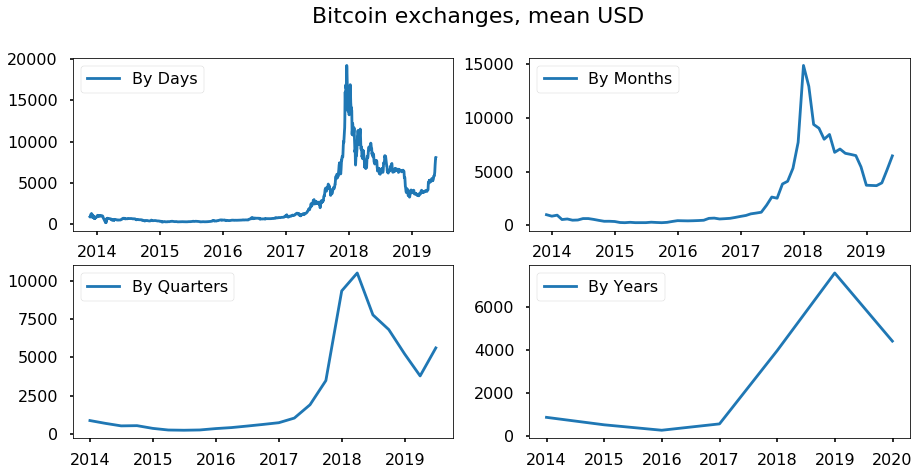

In [31]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(hist.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(hist_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(hist_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(hist_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

In [32]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [33]:
train, test = train_test_split(hist, test_size=0.1)

Dickey–Fuller test: p=0.375755


<Figure size 1080x504 with 0 Axes>

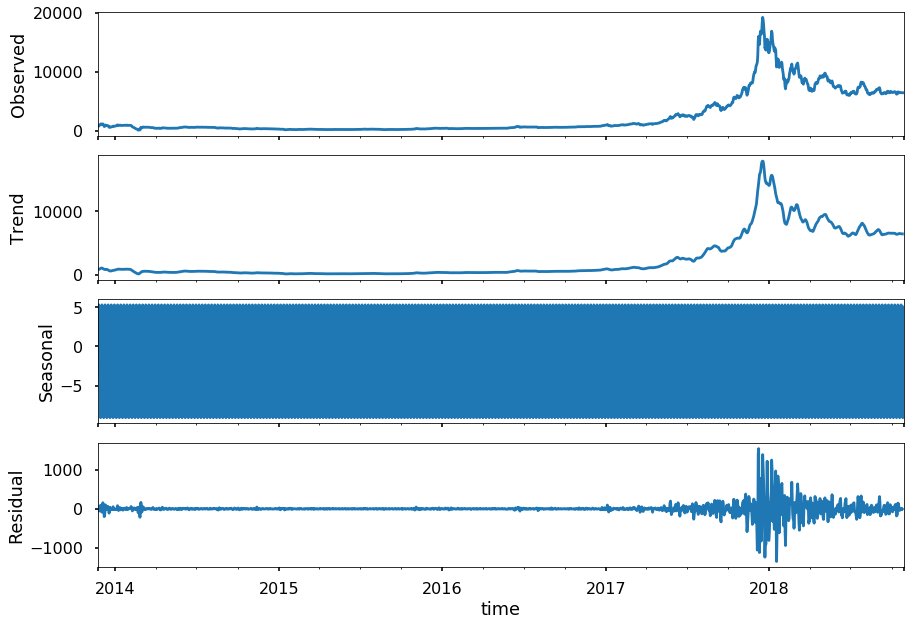

In [34]:
#Stationarity check and STL-decomposition of the series

plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(train.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(train.Weighted_Price)[1])
plt.show()

In [35]:
# Box-Cox Transformations
train['Weighted_Price_box'], lmbda = stats.boxcox(train.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(train.Weighted_Price)[1])

Dickey–Fuller test: p=0.375755


In [36]:
#Seasonal differentiation
train['prices_box_diff'] = train.Weighted_Price_box - train.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(train.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.000000


Dickey–Fuller test: p=0.000000


<Figure size 1080x504 with 0 Axes>

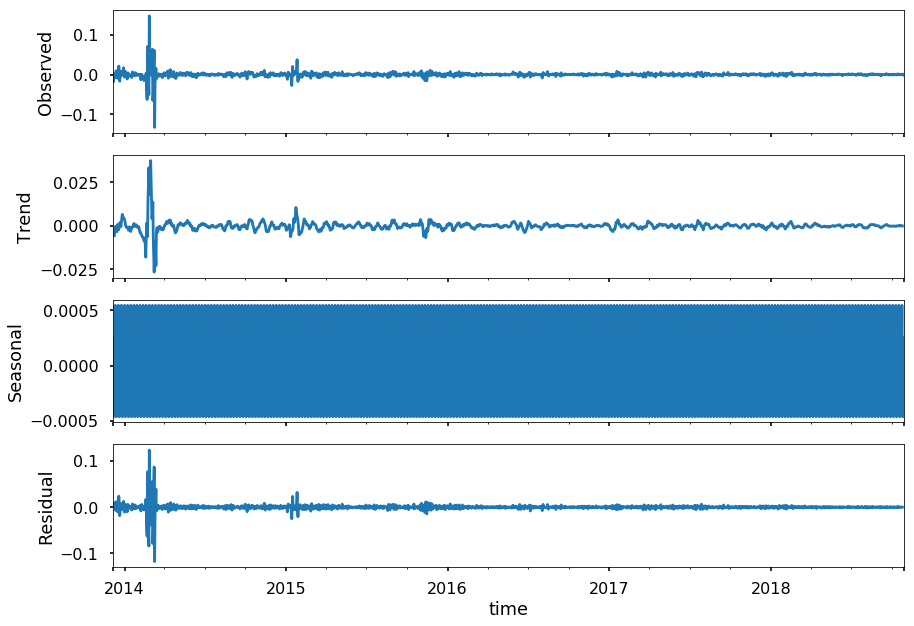

In [37]:
#as the pvalue is more than the threshold i.e 5% we conclude : The series are not stationary.

# Regular differentiation
train['prices_box_diff2'] = train.prices_box_diff - train.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(train.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(train.prices_box_diff2[13:])[1])

plt.show()

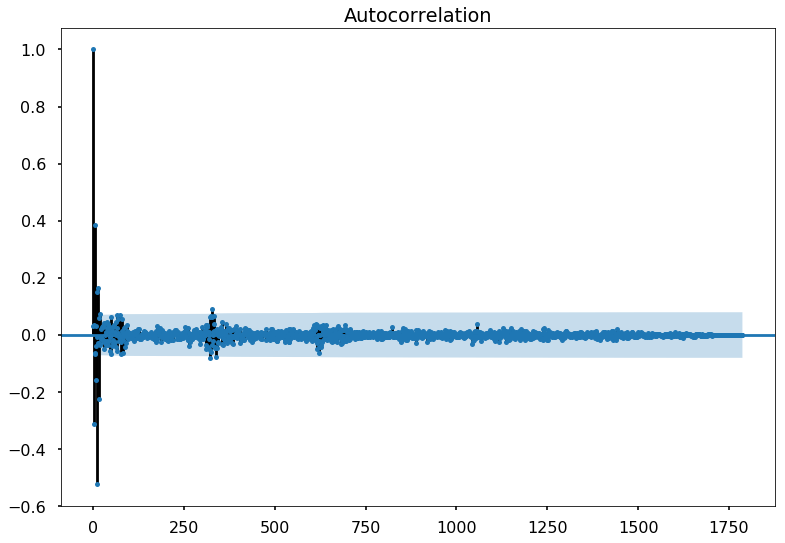

In [38]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train.prices_box_diff2[13:].values.squeeze())
pyplot.show()

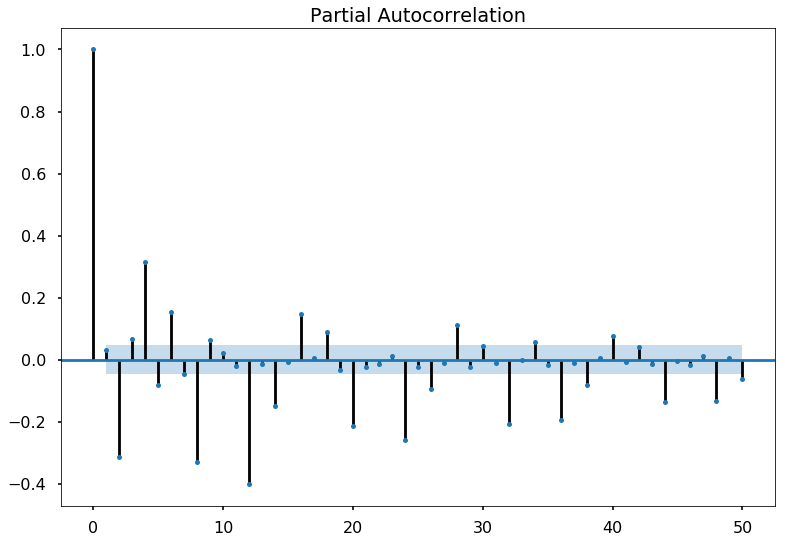

In [61]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train.prices_box_diff2[13:].values.squeeze(), lags=50)
pyplot.show()

In [55]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(train.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    except np.linalg.LinAlgError as err:
        print('LinAlgError:', err)
        break
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

LinAlgError: Singular matrix


In [56]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters           aic
15  (0, 2, 1, 1) -13908.259791
5   (0, 0, 2, 1) -13805.444981
23  (1, 0, 2, 1) -13804.730986
27  (1, 1, 1, 1) -13804.684962
1   (0, 0, 0, 1) -13802.745926
                                 Statespace Model Results                                 
Dep. Variable:                 Weighted_Price_box   No. Observations:                 1801
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 12)   Log Likelihood                6959.130
Date:                            Fri, 17 May 2019   AIC                         -13908.260
Time:                                    11:01:39   BIC                         -13880.816
Sample:                                11-23-2013   HQIC                        -13898.126
                                     - 10-28-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------

Dickey–Fuller test:: p=0.000000


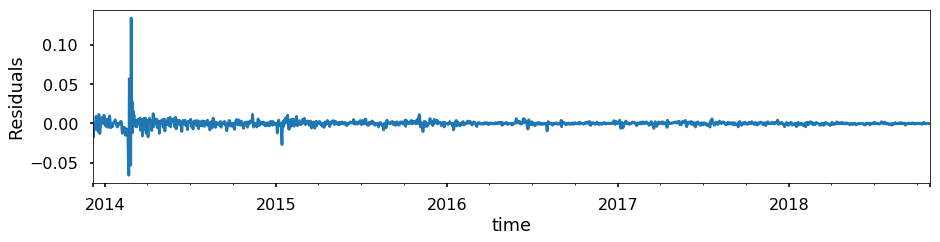

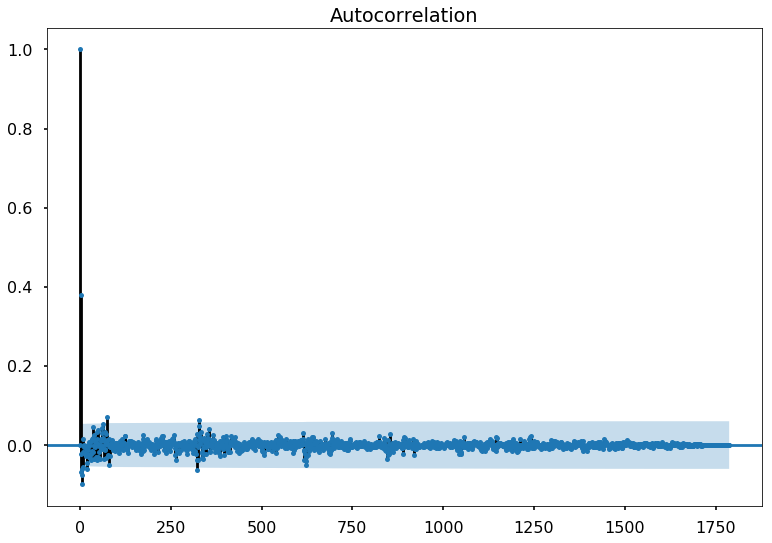

In [57]:
# STL-decomposition

from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf



plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

plot_acf(best_model.resid[13:].values.squeeze())

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

pyplot.show()

In [58]:
#Prediction 
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

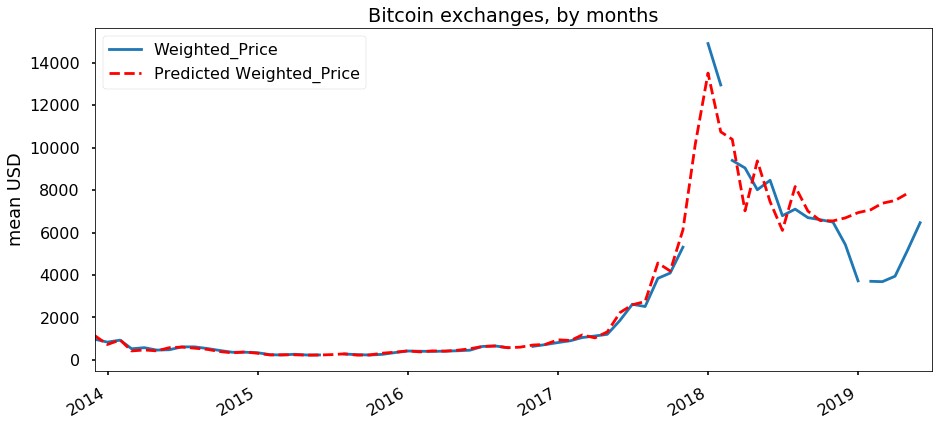

In [59]:

hist_month2 = hist_month[['Weighted_Price']]
date_list = [datetime(2015, 6, 30), datetime(2015, 7, 31), datetime(2016, 8, 31), datetime(2016, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2018, 12, 31), datetime(2018, 1, 31),
             datetime(2019, 6, 28)]
future = pd.DataFrame(index=date_list, columns= hist_month.columns)
hist_month2 = pd.concat([hist_month2, future])
hist_month2['forecast'] = invboxcox(best_model.predict(start=0, end=len(hist)), lmbda)
plt.figure(figsize=(15,7))
hist_month2.Weighted_Price.plot()
hist_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()